# Card Classifier

---

#### 1. Preparing the data

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from tqdm.notebook import tqdm

import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import sys

In [2]:
print('System:', sys.version)
print('PyTorch:', torch.__version__)
print('Torchvision:', torchvision.__version__)
print('Numpy:', np.__version__)
print('Pandas:', pd.__version__)

System: 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:52:34) [Clang 18.1.8 ]
PyTorch: 2.5.1
Torchvision: 0.20.1
Numpy: 1.26.4
Pandas: 2.3.1


In [3]:
class CardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [4]:
data_dir = '../data/train'

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [6]:
dataset = CardDataset(data_dir, transform)

In [7]:
len(dataset)

7624

In [8]:
img, lbl = dataset[1000]

In [9]:
img.shape, lbl

(torch.Size([3, 128, 128]), 6)

In [10]:
data_dir = '../data/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
#print(target_to_class)

In [11]:
dataloader = DataLoader(dataset, batch_size=34, shuffle=True)

In [12]:
for img, lbl in dataloader:
    break

In [13]:
img.shape

torch.Size([34, 3, 128, 128])

In [14]:
lbl

tensor([34, 31, 33, 14, 12, 18, 11,  7,  4, 17, 24, 20, 44, 40, 50, 17, 22, 43,
        38,  8, 10, 45, 45,  8, 32, 37, 29, 34, 45, 30, 51, 36,  5, 10])

---

#### 2. Creating the model

In [15]:
class CardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(CardClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        self.classifier = nn.Linear(enet_out_size, num_classes)

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [16]:
model = CardClassifier(num_classes=53)

In [17]:
print(str(model)[:500])

CardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
 


In [18]:
eg_out = model(img)
eg_out.shape

torch.Size([34, 53])

---

#### 3. Training the model

In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# criterion(eg_out, lbl)

In [22]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_folder = '../data/train/'
valid_folder = '../data/valid/'
test_folder = '../data/test/'

train_dataset = CardDataset(train_folder, transform=transform)
valid_dataset = CardDataset(valid_folder, transform=transform)
test_dataset = CardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = CardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5692755399821063, Validation loss: 0.40296697121746133


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5589528396522386, Validation loss: 0.15947707531587133


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.32091684911521257, Validation loss: 0.1294497789920501


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.2448380624119032, Validation loss: 0.15023160318158707


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.20028326734665933, Validation loss: 0.2152654636862143


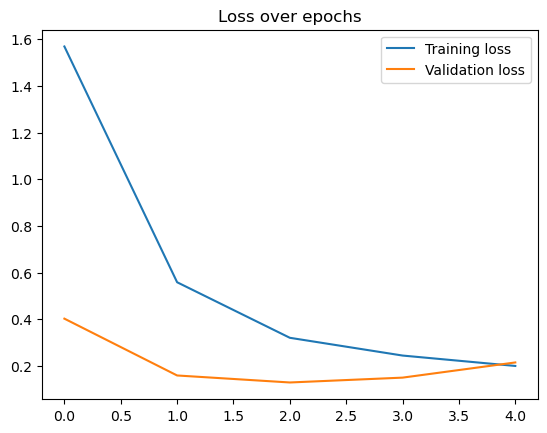

In [26]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

---

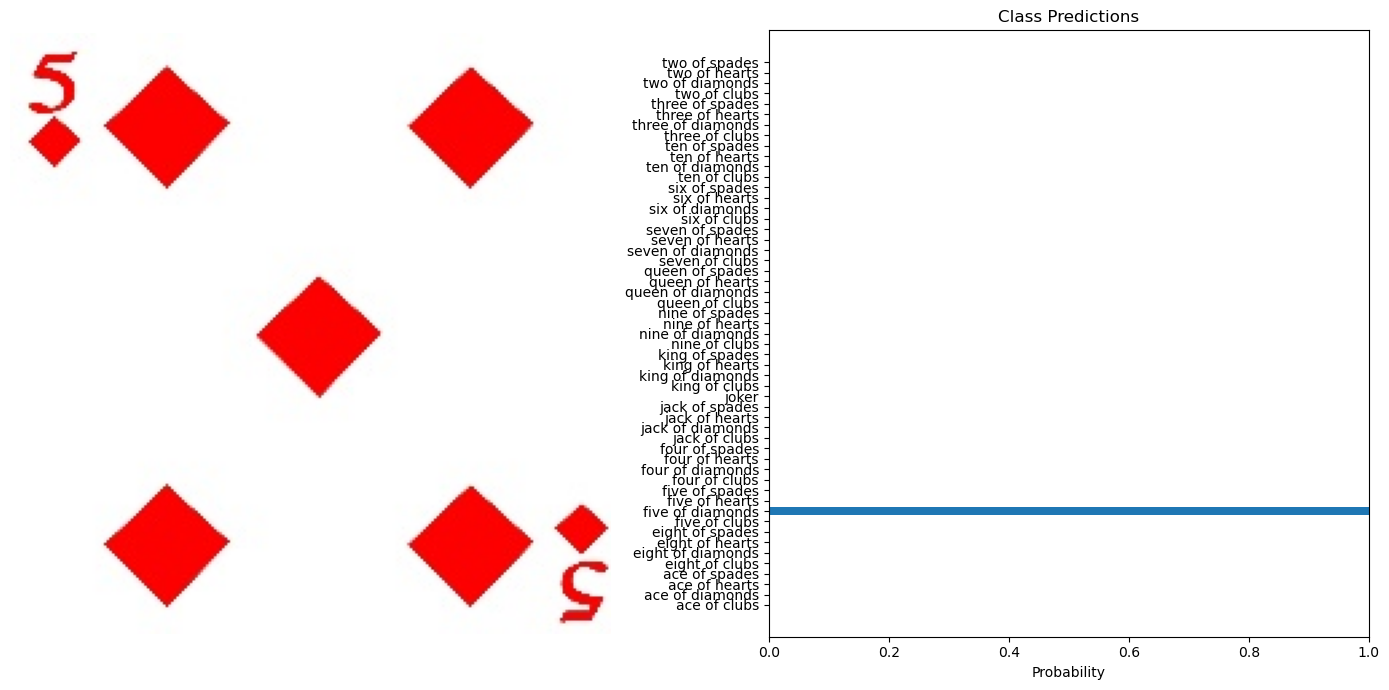

In [28]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "../data/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

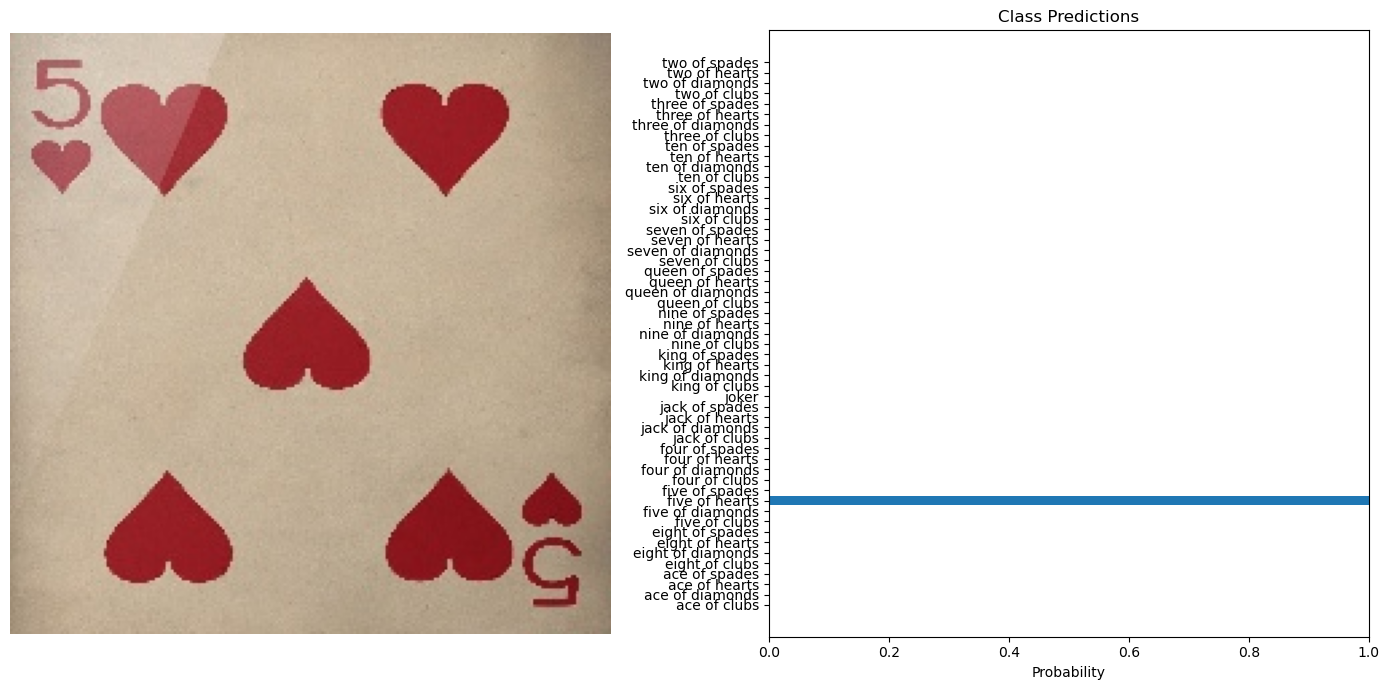

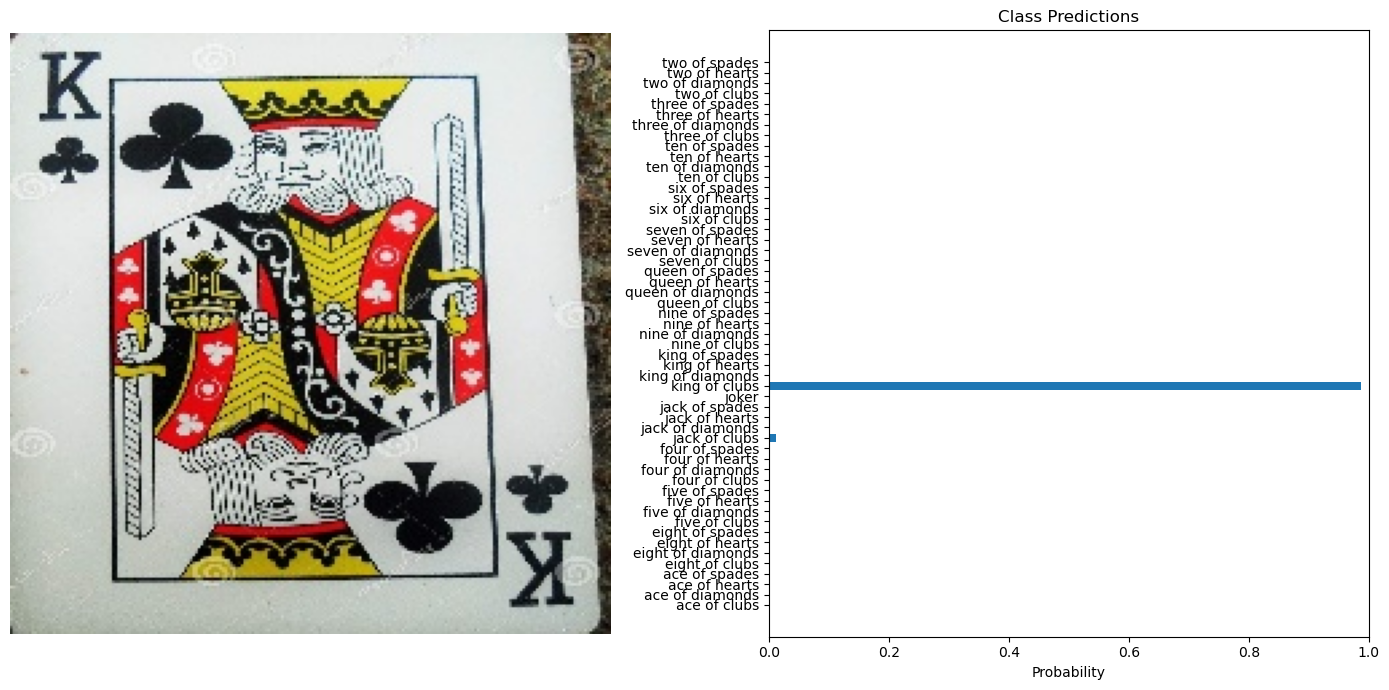

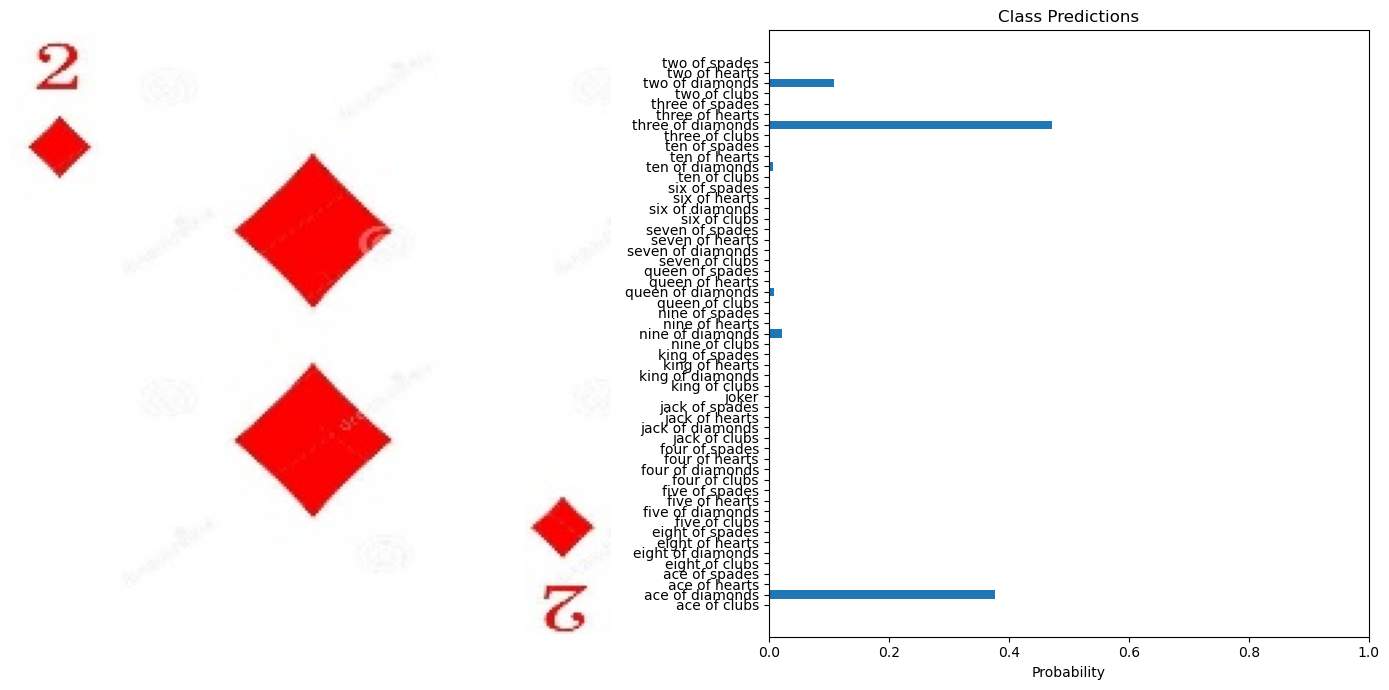

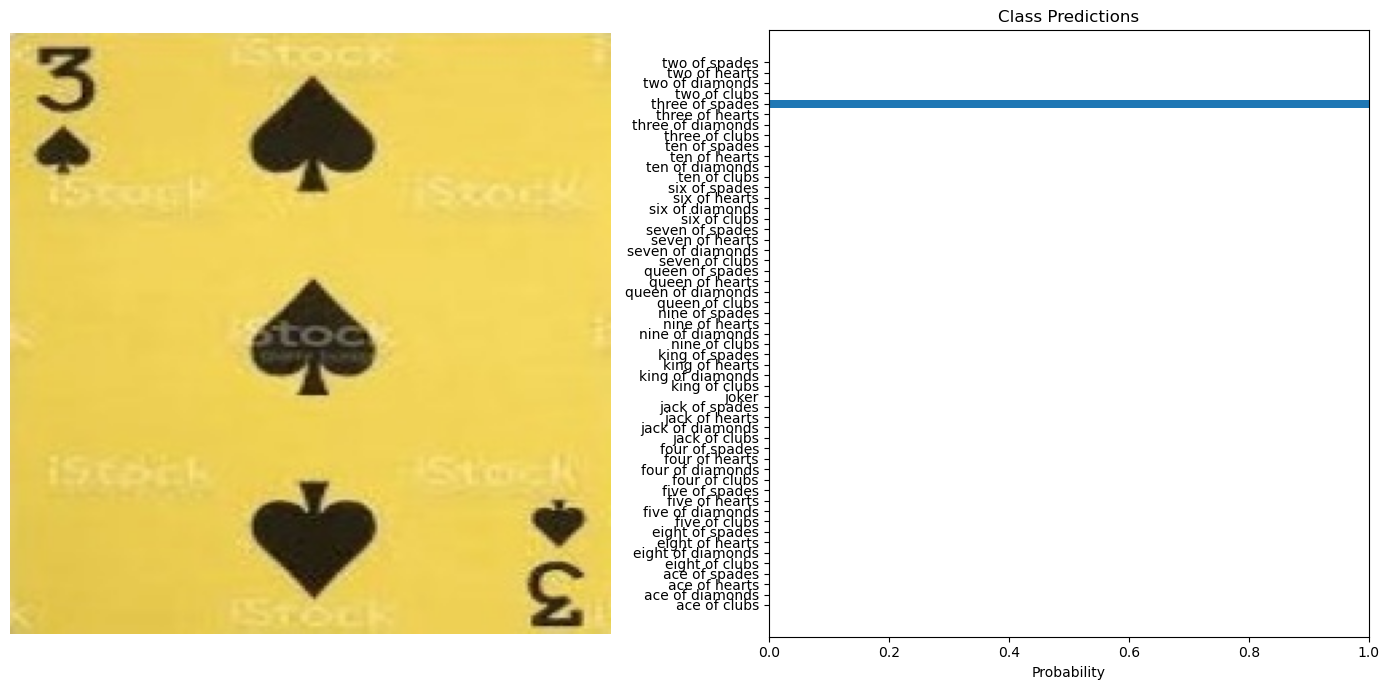

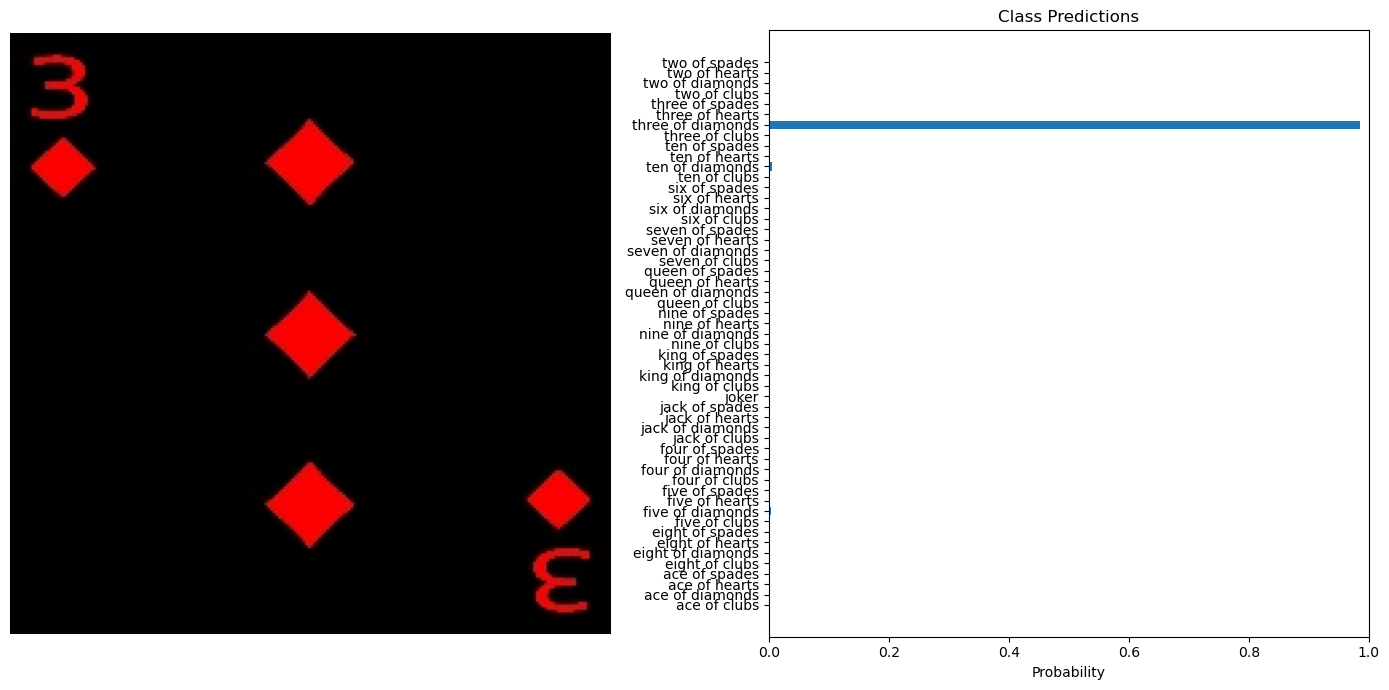

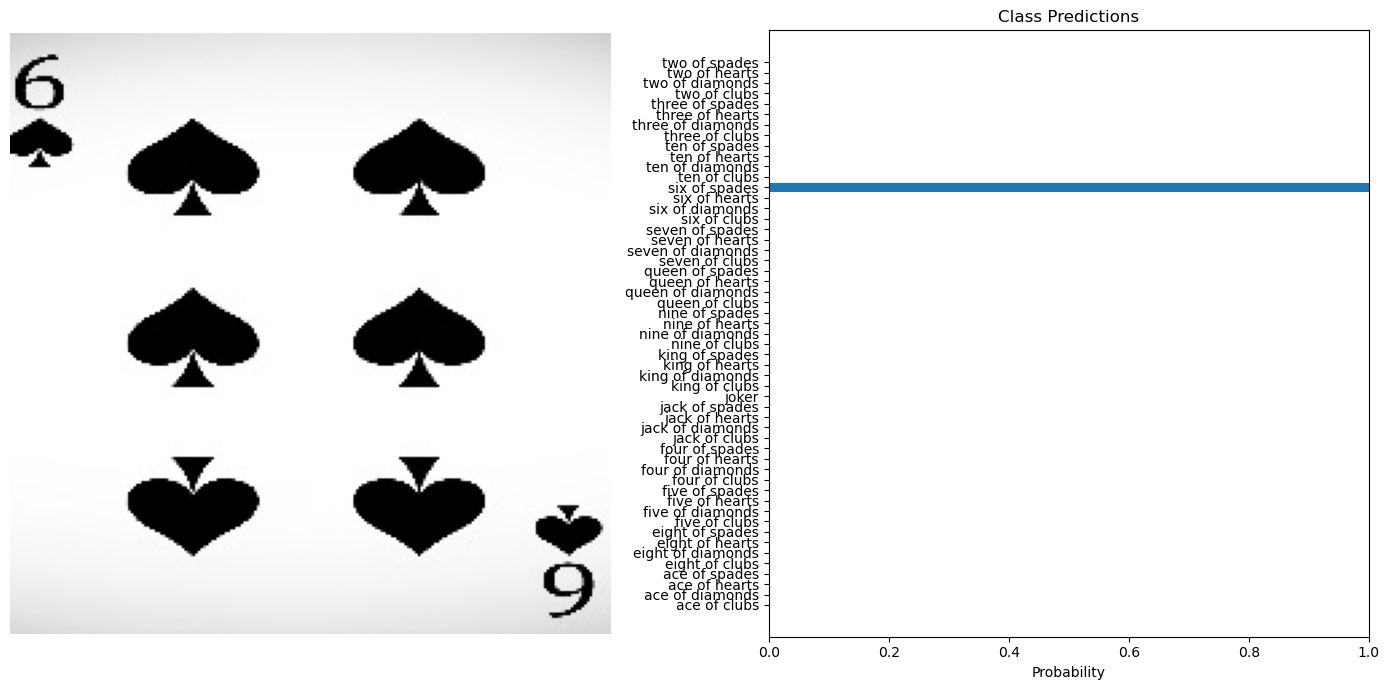

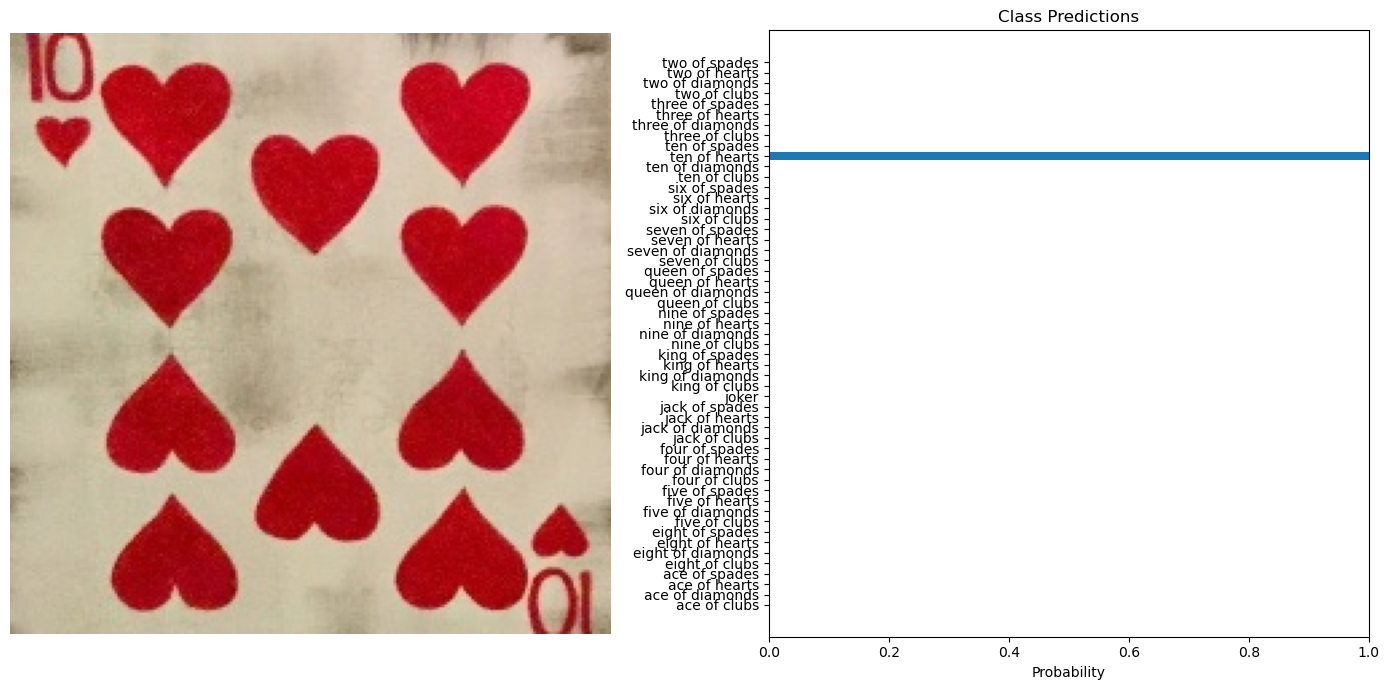

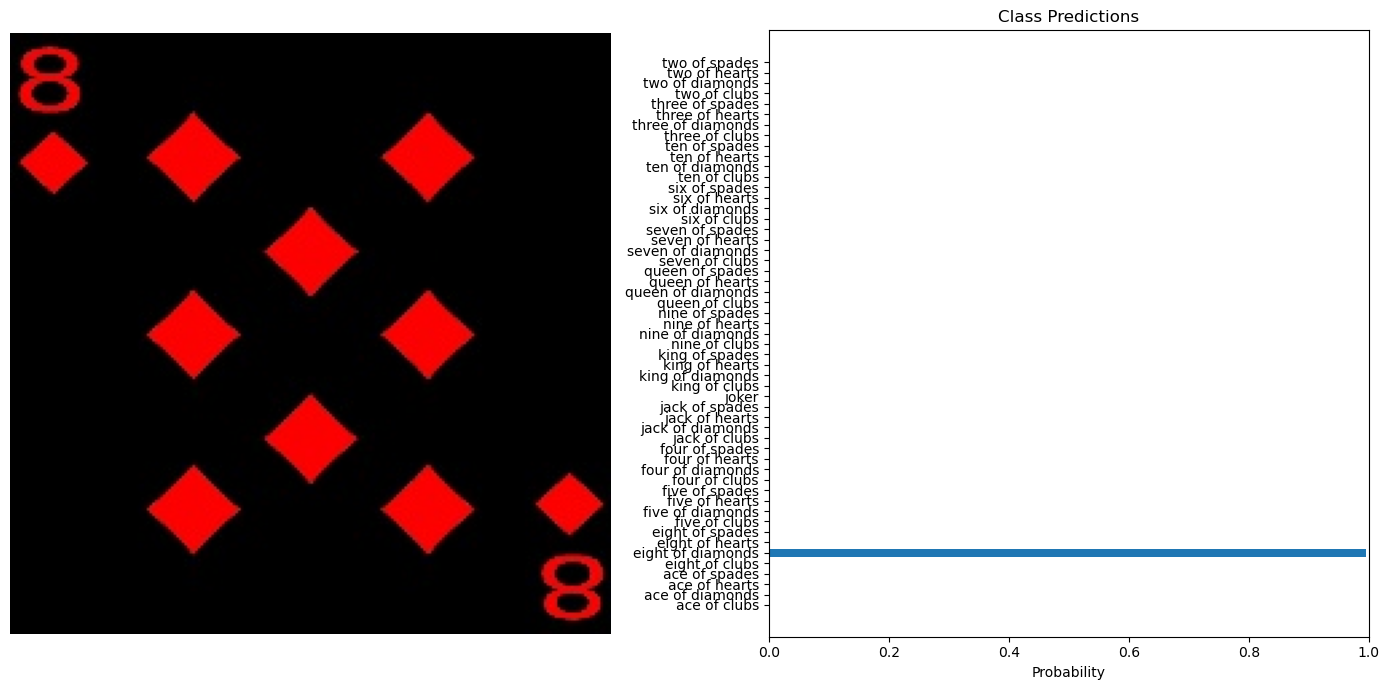

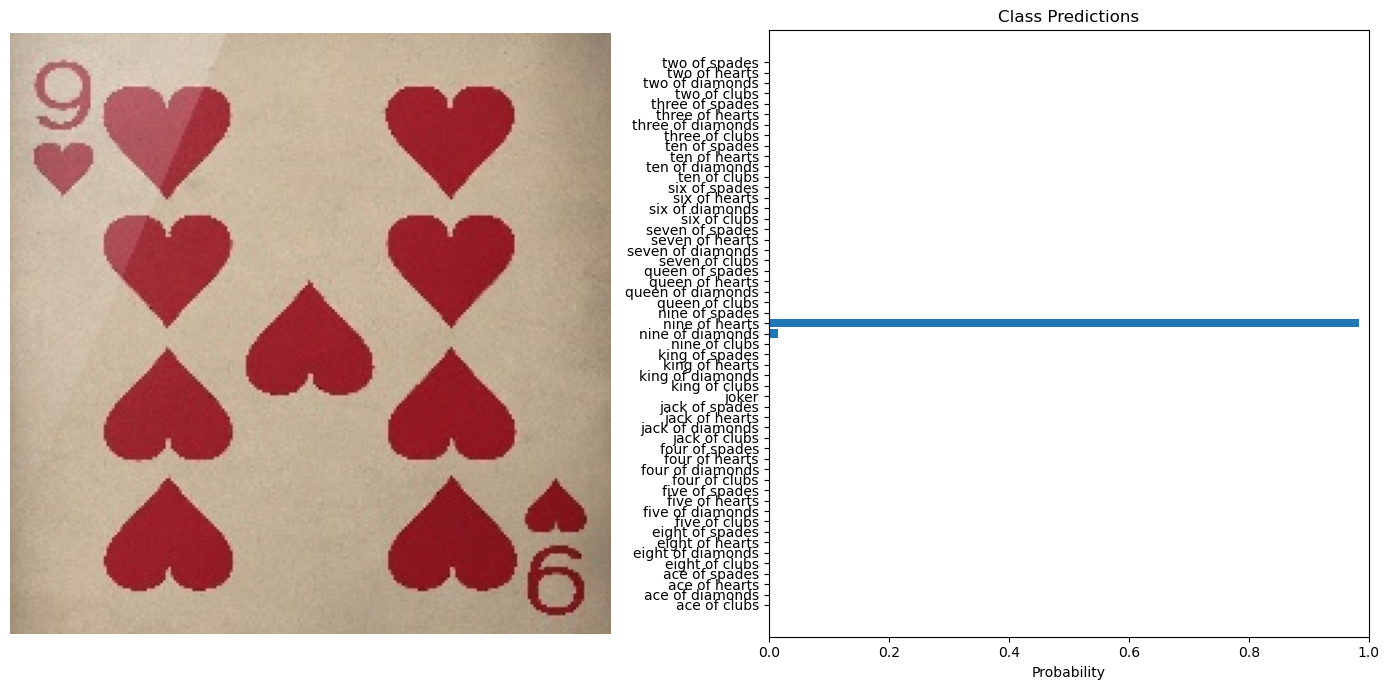

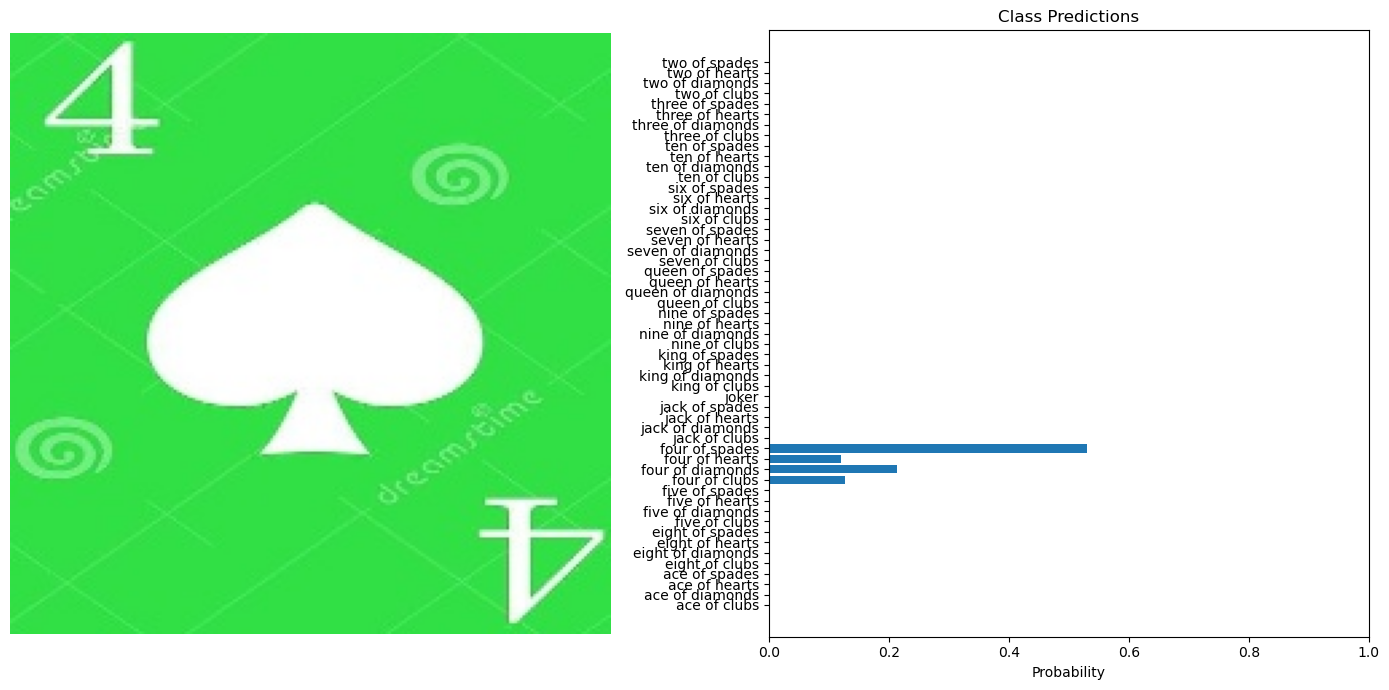

In [36]:
from glob import glob
test_images = glob('../data/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)